#                              TV News Commercial Detection

### Load The libraries


import pandas as pd

import findspark
findspark.init()
findspark.find()
import pyspark
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
conf = pyspark.SparkConf().setAppName('appName2').setMaster('local')
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession(sc)
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)


In [2]:
# Functionality for computing features
from pyspark.ml import feature
# Functionality for regression
from pyspark.ml import regression
# Funcionality for classification
from pyspark.ml import classification
# Object for creating sequences of transformations
from pyspark.ml import Pipeline,evaluation
import re

In [3]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics

In [4]:
from pyspark.sql import functions as fn
import numpy as np
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml import PipelineModel
from pyspark.ml.feature import Imputer
import seaborn as sns
import pickle
from pyspark.ml.classification import LinearSVC
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import GBTClassifier


In [ ]:
import ipywidgets as widgets
from ipywidgets import HBox, VBox
from IPython.display import clear_output
import pprint

# Index

- [Logistic Regression](#Logistic-Regression)
- [Random Forest](#Random-Forest)
- [Gradient Boosting](#Gradient-Boosting-Trees)
- [GO TO DEMO](#Demo)

## Data retrieval and cleaning

Please find the dataset here:
[TV commercial Data Set](https://archive.ics.uci.edu/ml/datasets/TV+News+Channel+Commercial+Detection+Dataset)

steps:-

- Download the zip folder
- unzip it and give the path to the folder in the variable ' tvcommercials_path '

The Function below will combine data from 5 TV news channels

In [ ]:
tvcommercials_path = '/home/jovyan/ist718/Sourabh Ghosh Notebooks/'
filename=['BBC','NDTV','CNNIBN','TIMESNOW','CNN']
df_name = []
def read_files(path):
    for file in filename:
        df_name.append(pd.read_table(path+file+'.txt', header=None))
    return df_name

In [ ]:
#Following function is performing data cleaning for producing the result in csv file from lib svm format
def data_clean(df_actual):
    s = df_actual[0].str.split(' ')
    for x in s:
        x[0] = re.sub('^', 'Label:', x[0])
    m = [list(w for w in x if w)for x in s]
    d = [dict(w.split(':') for w in x) for x in m]
    cols = sorted(d, key=len, reverse=True)[0].keys()
    df = pd.DataFrame.from_records(d,columns=cols)
    df_cols = list(df.columns)
    df_cols.remove('Label')
    df_cols = list(map(int, df_cols))
    df_cols.sort()
    df_cols = list(map(str, df_cols))
    df_cols.append('Label')
    df = df[df_cols]
    df = df.fillna('NA')
    df.to_csv("TV_Commercials_Cleaned.csv", index=False)

In [ ]:
df_actual = read_files(tvcommercials_path)
dataframe_tv = pd.concat(df_actual)
data_clean(dataframe_tv)

### Loading the combined data from 5 channels

In [5]:
tv=pd.read_csv('C:/Users/mihir/Desktop/sem2/IST718/dataset/TV_Commercials_Cleaned.csv')

In [6]:
tv.shape

(129685, 205)

In [3]:
#Removing columns having more than 25% null values 
imputed_tv=tv.loc[:,((tv.isnull().sum()/tv.shape[0])*100)<25]

NameError: name 'tv' is not defined

### Mapping Column numbers with column names

In [ ]:
MotionDist=[2,3]
FrameDiff=[4,5]
ShortTime=[6,7]
ZCR=[8,9]
SpectralCentroid=[10,11]
SpectralRoll=[12,13]
SpectralFlux=[14,15]
FundamentalFreq=[16,17]
EdgeChange=[4124,4125]
MotionDistbins=[*range(18, 59)]
FrameDiffbins=[*range(59, 92)]
TextAreaDistbins=[*range(92, 123)]
BagAudioWordsbins=[*range(123,4124)] 
l_MotionDist=list()

for m in range(0,len(MotionDistbins)):
    l_MotionDist.append("Motion Distribution bin_"+ str(MotionDistbins[m]))

l_FrameDiff=list()
for f in range(0,len(FrameDiffbins)):
    l_FrameDiff.append("Frame Difference bin_"+ str(FrameDiffbins[f]))
    

l_TextArea=list()
for t in range(0,len(TextAreaDistbins)):
    l_TextArea.append("Text Area Distribution bin_"+ str(TextAreaDistbins[t]))

l_BagAudioWords=list()
for b in range(0,len(BagAudioWordsbins)):
    l_BagAudioWords.append("Bag Audio Words bin_"+ str(BagAudioWordsbins[b]))
    
tv_dict={ 1: "Shot Length" ,
        MotionDist[0] : "Motion Distribution Mean",
        MotionDist[1] : "Motion Distribution Variance",
        FrameDiff[0]: 'Frame Difference Distribution Mean',
        FrameDiff[1]: 'Frame Difference Distribution Variance',
        ShortTime[0] : 'Short time energy Mean',
        ShortTime[1] : 'Short time energy Variance',
        ZCR[0] : 'ZCR Mean',
        ZCR[1] : 'ZCR Variance',
        SpectralCentroid[0]:'SpectralCentroid Mean',
        SpectralCentroid[1]:'SpectralCentroid Variance',
        SpectralRoll[0]: 'Spectral Roll off Mean',
        SpectralRoll[1]: 'Spectral Roll off Variance',
        SpectralFlux[0]:'Spectral Flux Mean',
        SpectralFlux[1]:'Spectral Flux Variance',
        FundamentalFreq[0]: 'Fundamental Frequecy Mean',
        FundamentalFreq[1]:'Fundamental Frequecy Variance',
        EdgeChange[0]:'Edge Change Ratio Mean',
        EdgeChange[1]:'Edge Change Ratio Variance',       
}

for i in range(0,len(MotionDistbins)):
    tv_dict[MotionDistbins[i]] = l_MotionDist[i]
    
for j in range(0,len(FrameDiffbins)):
    tv_dict[FrameDiffbins[j]] = l_FrameDiff[j]
    
for k in range(0,len(TextAreaDistbins)):
    tv_dict[TextAreaDistbins[k]] = l_TextArea[k]

for p in range(0,len(BagAudioWordsbins)):
    tv_dict[BagAudioWordsbins[p]] = l_BagAudioWords[p]

In [ ]:
pickle.dump(tv_dict,open('tv_pickle1.p','wb'))

In [14]:
objdict=open('C:/Users/mihir/Desktop/sem2/IST718/tv_pickle1.p','rb')


In [15]:
namedict=pickle.load(objdict)

In [16]:
namedict

{1: 'Shot Length',
 2: 'Motion Distribution Mean',
 3: 'Motion Distribution Variance',
 4: 'Frame Difference Distribution Mean',
 5: 'Frame Difference Distribution Variance',
 6: 'Short time energy Mean',
 7: 'Short time energy Variance',
 8: 'ZCR Mean',
 9: 'ZCR Variance',
 10: 'SpectralCentroid Mean',
 11: 'SpectralCentroid Variance',
 12: 'Spectral Roll off Mean',
 13: 'Spectral Roll off Variance',
 14: 'Spectral Flux Mean',
 15: 'Spectral Flux Variance',
 16: 'Fundamental Frequecy Mean',
 17: 'Fundamental Frequecy Variance',
 4124: 'Edge Change Ratio Mean',
 4125: 'Edge Change Ratio Variance',
 18: 'Motion Distribution bin_18',
 19: 'Motion Distribution bin_19',
 20: 'Motion Distribution bin_20',
 21: 'Motion Distribution bin_21',
 22: 'Motion Distribution bin_22',
 23: 'Motion Distribution bin_23',
 24: 'Motion Distribution bin_24',
 25: 'Motion Distribution bin_25',
 26: 'Motion Distribution bin_26',
 27: 'Motion Distribution bin_27',
 28: 'Motion Distribution bin_28',
 29: 'Moti

In [17]:
cols=imputed_tv.columns
cols=[int(i) for i in cols[:-1]]
colnames=[namedict[i] for i in cols]
colnames.append('Label')

In [19]:
imputed_tv.columns=colnames

In [20]:
imputed_tv.head()

,Shot Length,Motion Distribution Mean,Motion Distribution Variance,Frame Difference Distribution Mean,Frame Difference Distribution Variance,Short time energy Mean,Short time energy Variance,ZCR Mean,ZCR Variance,SpectralCentroid Mean,...,Text Area Distribution bin_118,Text Area Distribution bin_119,Bag Audio Words bin_491,Bag Audio Words bin_572,Bag Audio Words bin_573,Bag Audio Words bin_623,Bag Audio Words bin_816,Edge Change Ratio Mean,Edge Change Ratio Variance,Label
0,123,1.316440,1.516003,5.605905,5.346760,0.013233,0.010729,0.091743,0.050768,3808.067871,...,0.251688,0.176144,0.069915,0.141949,0.103814,0.050847,0.036017,0.422334,0.663918,1
1,124,0.966079,0.546420,4.046537,3.190973,0.008338,0.011490,0.075504,0.065841,3466.266113,...,0.206926,0.051774,0.075630,0.012605,0.037815,0.086134,0.023109,0.332664,0.766184,1
2,109,2.035407,0.571643,9.551406,5.803685,0.015189,0.014294,0.094209,0.044991,3798.196533,...,0.185767,0.038852,0.069712,0.038462,0.088942,0.139423,0.052885,0.346674,0.225022,1
3,86,3.206008,0.786326,10.092709,2.693058,0.013962,0.011039,0.092042,0.043756,3761.712402,...,0.165600,0.003983,0.135802,0.012346,0.086420,0.212963,0.077160,0.993323,0.840083,1
4,76,3.135861,0.896346,10.348035,2.651010,0.020914,0.012061,0.108018,0.052617,3784.488037,...,0.159495,0.000066,0.021127,0.007042,0.154930,0.151408,0.017606,0.341520,0.710470,1


In [21]:
cor = imputed_tv.corr()

In [22]:
import numpy as np

### Removed columns with 95 % correlation

In [23]:
# Create correlation matrix
corr_matrix = imputed_tv.corr().abs()

# # Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# # Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
imputed_tv_reduced=imputed_tv.drop(imputed_tv[to_drop], axis=1)

### Mean Imputation

In [24]:
imputed_tv_reduced=imputed_tv_reduced.fillna(-9999)

In [30]:
tv_spark_df = sqlContext.createDataFrame(imputed_tv_reduced)

In [31]:
#Label:0 for non-commercials,1 for commercials 
tv_spark_df=tv_spark_df.withColumn('Label',fn.when(fn.col('Label')==-1,0.).otherwise(1))

In [32]:
#as float
from pyspark.sql.functions import col
tv_spark_df=tv_spark_df.select(*(col(c).cast("float").alias(c) for c in tv_spark_df.columns))

In [35]:
mean_imp=Imputer(strategy='mean',inputCols=tv_spark_df.columns,outputCols=tv_spark_df.columns,missingValue=-9999)

In [36]:
imp_trans=mean_imp.fit(tv_spark_df)

In [37]:
tv_spark_df=imp_trans.transform(tv_spark_df)

### Exploratory Data Analysis

In [5]:
imputed_tv.boxplot(column=['Motion Distribution Mean'],showfliers=False)

NameError: name 'imputed_tv' is not defined

In [ ]:
ax = sns.boxplot(x="Label", y="Fundamental Frequecy Mean", data=imputed_tv,showfliers=False)

In [ ]:
imputed_tv[imputed_tv['Shot Length'] < 500].hist(column='Shot Length',bins =20)

In [39]:
tv_spark_df.groupBy('Label').agg(fn.count('Label')).toPandas().plot.bar(x='Label', y='count(Label)')

In [40]:
#Descriptive 
tv_spark_df.select('Shot Length','Label').groupBy('Label').agg(fn.mean(fn.col('Shot Length')),fn.stddev(fn.col('Shot Length'))).show()

+-----+-----------------+------------------------+
|Label| avg(Shot Length)|stddev_samp(Shot Length)|
+-----+-----------------+------------------------+
|  1.0|63.58907224769248|      155.22723397282064|
|  0.0|180.5852193703376|      375.78641195459545|
+-----+-----------------+------------------------+



In [41]:
%matplotlib inline

Saving final data frame for future use 

In [44]:
#predictor feature list 
feat_list=tv_spark_df.columns[:-1]

## Stratified split

In [45]:
#Stratified Sampling 
training_df = tv_spark_df.sampleBy("label", fractions={0: 0.6, 1: 0.6}, seed=10)
valid_test_df = tv_spark_df.subtract(training_df)
validation_df = valid_test_df.sampleBy("label", fractions={0: 0.75, 1: 0.75}, seed=10)
testing_df_gen = valid_test_df.subtract(validation_df)
testing_df=testing_df_gen.sampleBy("label",fractions={0:0.99,1:0.99}, seed=10)
testing_df_unseen=testing_df_gen.subtract(testing_df)

### For the demo, saved models can be used to save time. Please find the saved models in the attachments and save them in the same directory. Run the below cell to load all the saved models.


In [ ]:
best_model=PipelineModel.load('bestmodel')
rf_best=PipelineModel.load('best_model_rf')
best_model_gbt=PipelineModel.load('best_model_gbt')

# Logistic Regression

- [Index](#Index)

Feature Engineering Steps 

In [24]:
#feature assembler and scaling pipeline 
pipe1tv=Pipeline(stages=[feature.VectorAssembler(inputCols=feat_list,outputCol='features'),feature.StandardScaler(inputCol='features',outputCol='scaled',withMean=True)])

In [25]:
#Logistic Regression Pipeline with Elastic net Regularization
lr = LogisticRegression(regParam=0.1, elasticNetParam=0.1,featuresCol='scaled',labelCol='Label')
lr_pipe=Pipeline(stages=[pipe1tv,lr]).fit(training_df)
lr_est=Pipeline(stages=[pipe1tv,lr])

In [26]:
valid_df=lr_pipe.transform(validation_df)

In [27]:
#Defining the evaluator
evaluator = evaluation.BinaryClassificationEvaluator(labelCol='Label')

In [83]:
non_zerobool=[i!=0 for i in lr_pipe.stages[-1].coefficients.toArray().tolist()]

In [84]:
from itertools import compress
list(compress(feat_list,non_zerobool))

['Shot Length',
 'Motion Distribution Variance',
 'Frame Difference Distribution Mean',
 'Frame Difference Distribution Variance',
 'Short time energy Mean',
 'Short time energy Variance',
 'ZCR Mean',
 'SpectralCentroid Mean',
 'SpectralCentroid Variance',
 'Spectral Flux Variance',
 'Fundamental Frequecy Mean',
 'Fundamental Frequecy Variance',
 'Motion Distribution bin_19',
 'Motion Distribution bin_29',
 'Motion Distribution bin_58',
 'Frame Difference bin_59',
 'Frame Difference bin_62',
 'Frame Difference bin_63',
 'Frame Difference bin_70',
 'Frame Difference bin_71',
 'Frame Difference bin_75',
 'Frame Difference bin_76',
 'Frame Difference bin_77',
 'Frame Difference bin_79',
 'Frame Difference bin_80',
 'Text Area Distribution bin_92',
 'Text Area Distribution bin_103',
 'Text Area Distribution bin_104',
 'Text Area Distribution bin_117',
 'Text Area Distribution bin_119',
 'Bag Audio Words bin_572',
 'Bag Audio Words bin_573',
 'Bag Audio Words bin_623',
 'Bag Audio Words bi

Features:['Shot Length',
 'Short time energy Mean',
 'Short time energy Variance',
 'SpectralCentroid Variance',
 'Spectral Flux Variance',
 'Motion Distribution bin_58',
 'Frame Difference bin_59',
 'Text Area Distribution bin_104',
 'Text Area Distribution bin_119',
 'Bag Audio Words bin_572',
 'Bag Audio Words bin_573',
 'Bag Audio Words bin_816']

In [77]:
import numpy as np
paramlist=np.arange(0.1,1, 0.1).tolist()

## Logistic Regression Tunegrid

In [94]:
def LRgrid(paramlist=paramlist):
    grid = ParamGridBuilder().\
    addGrid(lr_pipe.stages[-1].regParam, paramlist).\
    addGrid(lr_pipe.stages[-1].elasticNetParam, paramlist).\
    build()
    all_models = []
    for j in range(len(grid)):
        print("Fitting model {}".format(j+1))
        model = lr_est.fit(training_df, grid[j])
        all_models.append(model)
    AUC_scores=[evaluator.evaluate(m.transform(validation_df)) for m in all_models]
    best_model_idx = np.argmax(AUC_scores)
    print(grid[best_model_idx])
    best_model=all_models[best_model_idx]
    return {'AUC_list':AUC_scores,'Best Model':best_model}
    

In [95]:
lr_dict=LRgrid()

Fitting model 1
Fitting model 2
Fitting model 3
Fitting model 4
Fitting model 5
Fitting model 6
Fitting model 7
Fitting model 8
Fitting model 9
Fitting model 10
Fitting model 11
Fitting model 12
Fitting model 13
Fitting model 14
Fitting model 15
Fitting model 16
Fitting model 17
Fitting model 18
Fitting model 19
Fitting model 20
Fitting model 21
Fitting model 22
Fitting model 23
Fitting model 24
Fitting model 25
Fitting model 26
Fitting model 27
Fitting model 28
Fitting model 29
Fitting model 30
Fitting model 31
Fitting model 32
Fitting model 33
Fitting model 34
Fitting model 35
Fitting model 36
Fitting model 37
Fitting model 38
Fitting model 39
Fitting model 40
Fitting model 41
Fitting model 42
Fitting model 43
Fitting model 44
Fitting model 45
Fitting model 46
Fitting model 47
Fitting model 48
Fitting model 49
Fitting model 50
Fitting model 51
Fitting model 52
Fitting model 53
Fitting model 54
Fitting model 55
Fitting model 56
Fitting model 57
Fitting model 58
Fitting model 59
Fittin

In [85]:
best_model=lr_dict['Best Model']
#best_model=lr_pipe

In [ ]:
AUC_scores=[evaluator.evaluate(m.transform(validation_df)) for m in all_models]

In [44]:
best_model_idx = np.argmax(AUC_scores)

In [45]:
grid[best_model_idx]

{Param(parent='LogisticRegression_0e911d91fc10', name='regParam', doc='regularization parameter (>= 0)'): 0.1,
 Param(parent='LogisticRegression_0e911d91fc10', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty'): 0.1}

### Performance Evaluation

Note:- sklearn was used just for the classification report to get the F1 score. It was not used for any modelling purpose.

{Param(parent='LogisticRegression_0e911d91fc10', name='regParam', doc='regularization parameter (>= 0)'): 0.1,
 Param(parent='LogisticRegression_0e911d91fc10', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty'): 0.1}

In [46]:
AUC_scores[best_model_idx]

0.8820336105599562

In [99]:
#testing AUC
evaluator.evaluate(best_model.transform(testing_df))

0.8750436486897271

In [86]:
test_performance=best_model.transform(testing_df).select('Label','prediction').toPandas()

In [87]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test_performance['Label'],test_performance['prediction'])

array([[2264, 1451],
       [ 494, 5807]], dtype=int64)

In [88]:
from sklearn.metrics import classification_report
print(classification_report(test_performance['Label'], test_performance['prediction']))

              precision    recall  f1-score   support

         0.0       0.82      0.61      0.70      3715
         1.0       0.80      0.92      0.86      6301

    accuracy                           0.81     10016
   macro avg       0.81      0.77      0.78     10016
weighted avg       0.81      0.81      0.80     10016



In [89]:
#Non Zero Coefficients
non_zerobool=[i!=0 for i in best_model.stages[-1].coefficients.toArray().tolist()]
l1=list(compress(feat_list,non_zerobool))
l1

['Shot Length',
 'Motion Distribution Variance',
 'Frame Difference Distribution Mean',
 'Frame Difference Distribution Variance',
 'Short time energy Mean',
 'Short time energy Variance',
 'ZCR Mean',
 'SpectralCentroid Mean',
 'SpectralCentroid Variance',
 'Spectral Flux Variance',
 'Fundamental Frequecy Mean',
 'Fundamental Frequecy Variance',
 'Motion Distribution bin_19',
 'Motion Distribution bin_29',
 'Motion Distribution bin_58',
 'Frame Difference bin_59',
 'Frame Difference bin_62',
 'Frame Difference bin_63',
 'Frame Difference bin_70',
 'Frame Difference bin_71',
 'Frame Difference bin_75',
 'Frame Difference bin_76',
 'Frame Difference bin_77',
 'Frame Difference bin_79',
 'Frame Difference bin_80',
 'Text Area Distribution bin_92',
 'Text Area Distribution bin_103',
 'Text Area Distribution bin_104',
 'Text Area Distribution bin_117',
 'Text Area Distribution bin_119',
 'Bag Audio Words bin_572',
 'Bag Audio Words bin_573',
 'Bag Audio Words bin_623',
 'Bag Audio Words bi

### Important Features sorted according to absolute betas in decresing order

In [90]:
coeff_features=list(zip(list(compress(best_model.stages[-1].coefficients.toArray().tolist(),non_zerobool)),l1))

In [92]:

imp_features=pd.DataFrame()
imp_features["Feature"]=[i[1] for i in coeff_features]
imp_features["Beta Coefficient"]=[i[0] for i in coeff_features]
imp_features["Absolute Beta Coefficient"]=[abs(i[0]) for i in coeff_features]
imp_features.sort_values(by='Absolute Beta Coefficient', ascending=False)

,Feature,Beta Coefficient,Absolute Beta Coefficient
4,Short time energy Mean,0.376150,0.376150
8,SpectralCentroid Variance,0.357620,0.357620
5,Short time energy Variance,-0.323611,0.323611
15,Frame Difference bin_59,-0.314582,0.314582
9,Spectral Flux Variance,-0.272933,0.272933
30,Bag Audio Words bin_572,0.179397,0.179397
11,Fundamental Frequecy Variance,0.164319,0.164319
10,Fundamental Frequecy Mean,-0.146189,0.146189
0,Shot Length,-0.117725,0.117725
31,Bag Audio Words bin_573,0.110539,0.110539


In [114]:
#saved Logistic Regression model
best_model.save('bestmodel')

In [13]:
#best_model=PipelineModel.load('bestmodel')

# Random Forest

- [Index](#Index)

In [117]:
#create pipeline
rf = RandomForestClassifier(labelCol='Label', featuresCol='features',numTrees=60)
va=feature.VectorAssembler(inputCols=feat_list,outputCol='features')
rf_pipeline = Pipeline(stages=[va, rf]).fit(training_df)

In [43]:
rf_est=Pipeline(stages=[va, rf])

### Define TuneGrid

In [44]:
def randomForest(paramlist=[20,40,60,80,100,120,140,160,180,200]):
    from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
    grid = ParamGridBuilder().\
    addGrid(rf_pipeline.stages[-1].numTrees, paramlist).\
    build()
    all_models = []
    for j in range(len(grid)):
        print("Fitting model {}".format(j+1))
        model = rf_est.fit(training_df, grid[j])
        all_models.append(model)
    AUC_scores_rf=[evaluator.evaluate(m.transform(validation_df)) for m in all_models]
    AUC_scores_training_rf=[evaluator.evaluate(m.transform(training_df)) for m in all_models]
    AUC_both=[AUC_scores_training_rf,AUC_scores_rf]
    best_model_idx_rf = np.argmax(AUC_scores_rf)
    best_model_rf=all_models[best_model_idx_rf]
    print(grid[best_model_idx_rf])
    return {'AUC':AUC_both,'bestmodel':best_model_rf}
    
    
    
    

In [45]:
rmodel=randomForest()

Fitting model 1
Fitting model 2
Fitting model 3
Fitting model 4
Fitting model 5
Fitting model 6
Fitting model 7
Fitting model 8
Fitting model 9
Fitting model 10
{Param(parent='RandomForestClassifier_15ac2b838285', name='numTrees', doc='Number of trees to train (>= 1)'): 60}


### Graphical representation of hyperparameter tuning

In [70]:
rf_AUC=pd.DataFrame({'validation_AUC':rmodel['AUC'][1]},index=[20,40,60,80,100,120,140,160,180,200])



In [71]:
rf_AUC.index.rename('Trees')

Int64Index([20, 40, 60, 80, 100, 120, 140, 160, 180, 200], dtype='int64', name='Trees')

In [71]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Valdiation AUC score')

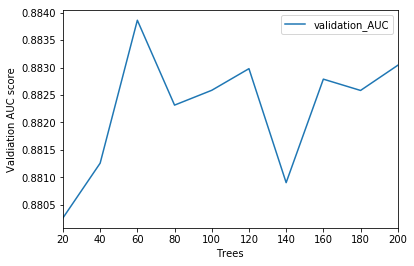

In [76]:
%matplotlib inline
rf_AUC.plot.line()
plt.xlabel('Trees')
plt.ylabel('Valdiation AUC score')

In [118]:
#rf_best=rmodel['bestmodel']
#rf_best=rf_pipeline

In [120]:
#save the best rf model 
rf_best.save('best_model_rf')

In [15]:
rf_best=PipelineModel.load('best_model_rf')

### Performance Evaluation

In [60]:
#testing AUC
evaluator.evaluate(rf_best.transform(testing_df))

0.8819837907738572

In [61]:
evaluator.evaluate(rf_best.transform(validation_df))

0.8800724330723372

In [79]:
test_performance_rf=rf_best.transform(testing_df).select('Label','prediction').toPandas()

In [83]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test_performance_rf['Label'],test_performance_rf['prediction'])

array([[2194, 1521],
       [ 421, 5880]], dtype=int64)

In [82]:

from sklearn.metrics import classification_report
print(classification_report(test_performance_rf['Label'], test_performance_rf['prediction']))

              precision    recall  f1-score   support

         0.0       0.84      0.59      0.69      3715
         1.0       0.79      0.93      0.86      6301

    accuracy                           0.81     10016
   macro avg       0.82      0.76      0.78     10016
weighted avg       0.81      0.81      0.80     10016



### Feature Importance( Random Forest)

In [93]:
rf_best.stages[-1].featureImportances

SparseVector(75, {0: 0.0826, 1: 0.0023, 2: 0.0072, 3: 0.0066, 4: 0.0008, 5: 0.0539, 6: 0.1307, 7: 0.0153, 8: 0.0009, 9: 0.0362, 10: 0.1068, 11: 0.01, 12: 0.111, 13: 0.0562, 14: 0.0279, 15: 0.0024, 16: 0.0237, 17: 0.0108, 18: 0.0032, 19: 0.0004, 20: 0.0001, 21: 0.0001, 22: 0.0004, 23: 0.0, 24: 0.0002, 25: 0.0, 26: 0.0013, 27: 0.0002, 28: 0.0012, 29: 0.0019, 30: 0.0008, 31: 0.0015, 32: 0.0017, 33: 0.0014, 34: 0.0001, 35: 0.001, 36: 0.001, 37: 0.0004, 38: 0.0006, 39: 0.0005, 40: 0.0001, 41: 0.0001, 42: 0.0003, 43: 0.0069, 44: 0.0793, 45: 0.0136, 46: 0.0028, 47: 0.0014, 48: 0.0021, 49: 0.0002, 50: 0.0002, 51: 0.0007, 52: 0.0012, 53: 0.0032, 54: 0.0004, 55: 0.0013, 56: 0.0037, 57: 0.0009, 58: 0.0004, 59: 0.0019, 60: 0.0027, 61: 0.0019, 62: 0.0203, 63: 0.0126, 64: 0.0, 65: 0.0007, 66: 0.0042, 67: 0.001, 68: 0.0003, 69: 0.0754, 70: 0.0449, 71: 0.0009, 72: 0.0111, 73: 0.0})

In [59]:
pd.DataFrame({'columns':validation_df.columns[:-1],'feature importance':rf_best.stages[-1].featureImportances}).sort_values('feature importance',ascending=False)[:20]

,columns,feature importance
6,Short time energy Variance,0.170662
10,SpectralCentroid Variance,0.117192
12,Spectral Flux Variance,0.116419
44,Frame Difference bin_59,0.090060
0,Shot Length,0.080903
69,Bag Audio Words bin_572,0.058476
13,Fundamental Frequecy Mean,0.048282
5,Short time energy Mean,0.043489
62,Text Area Distribution bin_103,0.029587
9,SpectralCentroid Mean,0.028696


### SVM Model( Not used for final analysis)

In [105]:
svm = LinearSVC(maxIter=5, regParam=0.01,featuresCol='scaled',labelCol='Label')

pipe2tv=Pipeline(stages=[feature.VectorAssembler(inputCols=feat_list,outputCol='features'),feature.StandardScaler(inputCol='features',outputCol='scaled',withMean=True)])
svm_pipeline = Pipeline(stages=[pipe2tv, svm]).fit(training_df)
svm_est=Pipeline(stages=[pipe2tv, svm])

In [108]:
def SVM(paramlist=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]):
    from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
    grid = ParamGridBuilder().\
    addGrid(svm_pipeline.stages[-1].regParam, paramlist).\
    build()
    all_models = []
    for j in range(len(grid)):
        print("Fitting model {}".format(j+1))
        model = svm_est.fit(training_df, grid[j])
        all_models.append(model)
    AUC_scores_svm=[evaluator.evaluate(m.transform(validation_df)) for m in all_models]
    AUC_scores_training_svm=[evaluator.evaluate(m.transform(training_df)) for m in all_models]
    AUC_both_svm=[AUC_scores_training_svm,AUC_scores_svm]
    best_model_idx_svm = np.argmax(AUC_scores_svm)
    best_model_svm=all_models[best_model_idx_svm]
    print(grid[best_model_idx_svm])
    return {'AUC':AUC_both_svm,'bestmodel':best_model_svm}
    
    

In [109]:
svm_dict=SVM()

Fitting model 1
Fitting model 2
Fitting model 3
Fitting model 4
Fitting model 5
Fitting model 6
Fitting model 7
Fitting model 8
Fitting model 9
{Param(parent='LinearSVC_b77908c69542', name='regParam', doc='regularization parameter (>= 0)'): 0.2}


# Gradient Boosting Trees

- [Index](#Index)

In [44]:
gbt=GBTClassifier( labelCol='Label')
va=feature.VectorAssembler(inputCols=feat_list,outputCol='features')
gbt_pipeline = Pipeline(stages=[va, gbt]).fit(training_df)

In [55]:
gbt_est=Pipeline(stages=[va, gbt])

### TuneGrid

In [59]:
def GBT(steplist=[0.05,0.1,0.15,0.2,0.25,0.3],depthlist=[3,4,5,6,7]):
    from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
    grid = ParamGridBuilder().\
    addGrid(gbt_pipeline.stages[-1].stepSize, steplist).\
    addGrid(gbt_pipeline.stages[-1].maxDepth,depthlist).\
    build()
    all_models = []
    for j in range(len(grid)):
        print("Fitting model {}".format(j+1))
        model = gbt_est.fit(training_df, grid[j])
        all_models.append(model)
    AUC_scores_gbt=[evaluator.evaluate(m.transform(validation_df)) for m in all_models]
    best_model_idx_gbt = np.argmax(AUC_scores_gbt)
    best_model_gbt=all_models[best_model_idx_gbt]
    print(grid[best_model_idx_gbt])
    return {'AUC':AUC_scores_gbt,'bestmodel':best_model_gbt}
    

In [60]:
gbt_dict=GBT()

Fitting model 1
Fitting model 2
Fitting model 3
Fitting model 4
Fitting model 5
Fitting model 6
Fitting model 7
Fitting model 8
Fitting model 9
Fitting model 10
Fitting model 11
Fitting model 12
Fitting model 13
Fitting model 14
Fitting model 15
Fitting model 16
Fitting model 17
Fitting model 18
Fitting model 19
Fitting model 20
Fitting model 21
Fitting model 22
Fitting model 23
Fitting model 24
Fitting model 25
Fitting model 26
Fitting model 27
Fitting model 28
Fitting model 29
Fitting model 30
{Param(parent='GBTClassifier_ac0e460cea75', name='stepSize', doc='Step size (a.k.a. learning rate) in interval (0, 1] for shrinking the contribution of each estimator.'): 0.3, Param(parent='GBTClassifier_ac0e460cea75', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 7}


In [63]:
#best_model_gbt=gbt_dict['bestmodel']

In [121]:
best_model_gbt.save('best_model_gbt')

In [29]:
best_model_gbt=PipelineModel.load('best_model_gbt')

### Performance Evaluation

In [64]:
evaluator.evaluate(best_model_gbt.transform(validation_df))

0.9453194611176545

In [30]:
evaluator.evaluate(best_model_gbt.transform(testing_df))

0.9527911606143646

In [65]:
test_performance_gbt=best_model_gbt.transform(testing_df).select('Label','prediction').toPandas()
from sklearn.metrics import confusion_matrix
confusion_matrix(test_performance_gbt['Label'],test_performance_gbt['prediction'])


array([[3041,  674],
       [ 524, 5777]], dtype=int64)

In [66]:
from sklearn.metrics import classification_report
print(classification_report(test_performance_gbt['Label'], test_performance_gbt['prediction']))

              precision    recall  f1-score   support

         0.0       0.85      0.82      0.84      3715
         1.0       0.90      0.92      0.91      6301

    accuracy                           0.88     10016
   macro avg       0.87      0.87      0.87     10016
weighted avg       0.88      0.88      0.88     10016



### Graphical representation of hyperparameter tuning

In [68]:
param=[]
for i in [0.05,0.1,0.15,0.2,0.25,0.3]:
    for j in [3,4,5,6,7]:
        param.append((i,j))
        

In [73]:
gbt_AUC=pd.DataFrame({'validation_AUC':gbt_dict['AUC']},index=param)


Text(0, 0.5, 'Valdiation AUC score')

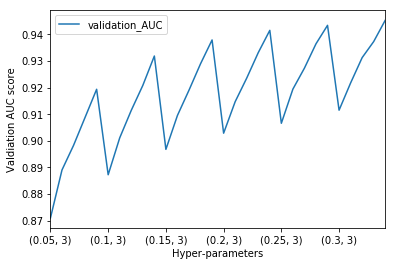

In [74]:
%matplotlib inline
gbt_AUC.plot.line()
plt.xlabel('Hyper-parameters')
plt.ylabel('Valdiation AUC score')

#### Number of trees

In [108]:
best_model_gbt.stages[-1].getNumTrees

20

### Feature Importance( GBT)

In [31]:
best_model_gbt.stages[-1].featureImportances

SparseVector(75, {0: 0.0146, 1: 0.0092, 2: 0.0141, 3: 0.0126, 4: 0.0158, 5: 0.0416, 6: 0.0553, 7: 0.0229, 8: 0.0134, 9: 0.0137, 10: 0.0249, 11: 0.0095, 12: 0.017, 13: 0.0248, 14: 0.0218, 15: 0.0111, 16: 0.0246, 17: 0.0091, 18: 0.0058, 19: 0.0071, 20: 0.0036, 21: 0.0031, 22: 0.0057, 23: 0.0054, 24: 0.0046, 25: 0.0034, 26: 0.0102, 27: 0.0044, 28: 0.0051, 29: 0.009, 30: 0.0021, 31: 0.0068, 32: 0.0029, 33: 0.0014, 34: 0.003, 35: 0.0007, 36: 0.0033, 37: 0.0038, 38: 0.0053, 39: 0.0015, 40: 0.0046, 41: 0.0055, 42: 0.0059, 43: 0.0137, 44: 0.0529, 45: 0.01, 46: 0.0068, 47: 0.0054, 48: 0.0083, 49: 0.008, 50: 0.0118, 51: 0.01, 52: 0.0084, 53: 0.0072, 54: 0.0097, 55: 0.0144, 56: 0.0089, 57: 0.0127, 58: 0.0072, 59: 0.0171, 60: 0.0317, 61: 0.0221, 62: 0.0286, 63: 0.0418, 64: 0.0194, 65: 0.0167, 66: 0.0211, 67: 0.0276, 68: 0.0174, 69: 0.0262, 70: 0.029, 71: 0.0121, 72: 0.0192, 73: 0.0027, 74: 0.0018})

In [39]:
pd.DataFrame({'columns':validation_df.columns[:-1],'feature importance':best_model_gbt.stages[-1].featureImportances}).sort_values('feature importance',ascending=False)[:20]

,columns,feature importance
6,Short time energy Variance,0.055342
44,Frame Difference bin_59,0.052945
63,Text Area Distribution bin_104,0.041775
5,Short time energy Mean,0.041550
60,Text Area Distribution bin_92,0.031658
70,Bag Audio Words bin_573,0.028977
62,Text Area Distribution bin_103,0.028603
67,Text Area Distribution bin_119,0.027595
69,Bag Audio Words bin_572,0.026196
10,SpectralCentroid Variance,0.024857


In [128]:
# testing_df_unseen_pandas.to_csv('C:/Users/mihir/Desktop/sem2/IST718/dataset/unseen.csv')

In [24]:
# testing_df_unseen_pandas=pd.read_csv('C:/Users/mihir/Desktop/sem2/IST718/dataset/unseen.csv')

In [5]:
# #INITIALISE
# tv_spark_pandas=pd.read_csv('C:/Users/mihir/Desktop/sem2/IST718/dataset/tv_spark_df.csv')
# tv_spark_df = sqlContext.createDataFrame(tv_spark_pandas)

# testing_df_unseen_pandas=pd.read_csv('C:/Users/mihir/Desktop/sem2/IST718/dataset/unseen.csv')


    

# Demo

- [Index](#Index)

### Run all the cells below and call the UI function for the demo

In [8]:
def get_prediction(b=None):
    clear_output()
    random=random_datapoint()
    
#Change the value for Shot Length by uncommemting the line below

    #random['Shot Length']=10
    print(random.head())
    tv_unseen_random= sqlContext.createDataFrame(random)
    global model_buttons
    print("")
    print(" Model Chosen is %s"%model_buttons.value)
    print("")
    if model_buttons.value=="Logistic_regression":
        return best_model.transform(tv_unseen_random).select('Label','prediction').show()
    if model_buttons.value=="Random_Forest":
        return rf_best.transform(tv_unseen_random).select('Label','prediction').show()
    if model_buttons.value=="Gradient_Boosting":
        return best_model_gbt.transform(tv_unseen_random).select('Label','prediction').show()
    
  



In [10]:
  model_buttons = widgets.ToggleButtons(
    options=['Logistic_regression', 'Random_Forest', 'Gradient_Boosting'],
    description='Model:',
)

In [11]:
button = widgets.Button(
    description='Predict',
)
button

Button(description='Predict', style=ButtonStyle())

In [12]:
@button.on_click
def trigger(b):
    get_prediction()

In [40]:
tab = widgets.Tab(children=[model_buttons])
tab.set_title(0, 'Choose a Model')

In [15]:
def UI():
    return VBox(children=[tab, button])

In [55]:
UI()


    Shot Length  Motion Distribution Mean  Motion Distribution Variance  \
87           10                  1.396926                      0.788251   

    Frame Difference Distribution Mean  \
87                            6.725489   

    Frame Difference Distribution Variance  Short time energy Mean  \
87                                 6.66836                0.024931   

    Short time energy Variance  ZCR Mean  ZCR Variance  SpectralCentroid Mean  \
87                    0.012927  0.083333      0.040474              3608.0908   

    ...  Text Area Distribution bin_118  Text Area Distribution bin_119  \
87  ...                        0.159063                        0.127946   

    Bag Audio Words bin_491  Bag Audio Words bin_572  Bag Audio Words bin_573  \
87                 0.006757                 0.135135                 0.263514   

    Bag Audio Words bin_623  Bag Audio Words bin_816  Edge Change Ratio Mean  \
87                 0.013514                 0.006757              